In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from mmctools.helper_functions import theta, power_spectral_density, calc_spectra
from windtools.common import calc_wind

In [4]:
from windtools.SOWFA6.postProcessing.averaging import PlanarAverages
from windtools.SOWFA6.postProcessing.probes import Probe
from windtools.SOWFA6.postProcessing.probeSets import ProbeSets
from windtools.plotting import plot_timeheight, plot_timehistory_at_height, plot_profile, plot_spectrum
from windtools.vtk import readVTK

In [5]:
def interpolate_to_heights(df,heights):
    """
    Interpolate data in dataframe to specified heights
    and return a new dataframe
    """
    from scipy.interpolate import interp1d
    
    # If single height is asked
    if isinstance(heights, (float,int)):
        heights=[heights]
    
    # Unstack to single height index (= most time-consuming operation)
    unstacked = df.unstack(level='datetime')
    # Interpolate to specified heights
    f = interp1d(unstacked.index,unstacked,axis=0,fill_value='extrapolate')
    for hgt in heights:
        unstacked.loc[hgt] = f(hgt)
    # Restack and set index
    df_out = unstacked.loc[heights].stack().reset_index().set_index(['datetime','height']).sort_index()
    return df_out


# Process and analysis of FINO1 SOWFA microscale case
This notebook uses processed data, generated by running `processFINOsowfa.ipynb` and `processFINOobs.ipynb`.

Regis Thedin \
April 2021

In [6]:
# Paths
vtkcasepath = '/projects/mmc/rthedin/OpenFOAM/rthedin-6/run/offshoreCases/02_fino_sampling/'
probecasepath = '/scratch/rthedin/OpenFOAM/rthedin-6/run/offshore/03_fino_sampling/'
obspath = '~/a2e-mmc/assessment/studies/fino_offshore_microscale/'
wrfpath = '/projects/mmc/rthedin/OpenFOAM/rthedin-6/run/offshoreCases'

In [7]:
figdir = os.path.join(vtkcasepath,'figures')
procdatadir = os.path.join(vtkcasepath,'processedFiles')

if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(procdatadir):
    os.makedirs(procdatadir)

## 1. Load data

### Times
Perform operations in time. OpenFOAM only deals with seconds.

- WRF data comes in `datetime` already and goes from `datefrom` to `dateto`.
- SOWFA time `0` is related to `dateref`. That is done to align the WRF output to forcing. We are interested in the time period that starts at `LESfrom` until `LESto`. We start the simulation 20,000s before that to allow spin-up time. Thus SOWFA's `startTime` is `LESspinupfrom`.

    SOWFA runs from 113200 s until 133200 s for spin-up. The value 113200 is `dateref` to `LESspinupfrom` in seconds.
    
    The 4-hour period of interest (and thus most data) is saved starting at 133200 s (`LESfrom`) until 147600 s (`LESto`). I have rounded-up the dates to get rid of the 3-s gap. 

In [8]:
# WRF
datefrom = pd.to_datetime('2010-05-14 12:00:03')
dateto = pd.to_datetime('2010-05-17 00:00:00')

# SOWFA
dateref = pd.to_datetime('2010-05-14 12:00:00')
LESfrom=pd.to_datetime('2010-05-16 01:00:00')
LESto=pd.to_datetime('2010-05-16 05:00:00')
LESspinupfrom = LESfrom - pd.Timedelta(seconds=20000)


### Load planar-average data

In [9]:
# Micro planar-average
padir = os.path.join(vtkcasepath,'postProcessing/planarAveraging')
dfpa = PlanarAverages(padir, varList=['U','T','UU','TU','wUU']).to_pandas()
dfpa.index.names = ['time','height']
dfpa = dfpa.rename(columns={ 'Ux':'u', 'Uy':'v', 'Uz':'w', 'T':'theta',
                             'UUxx':'uu', 'UUxy':'uv', 'UUxz':'uw', 'UUyy':'vv', 'UUyz':'vw', 'UUzz':'ww',
                             'TUx':'tu', 'TUy':'tv', 'TUz':'tw',
                             'wUUxx':'wuu', 'wUUxy':'wuv', 'wUUxz':'wuw', 'wUUyy':'wvv', 'wUUyz':'wvw', 'wUUzz':'www'
                       })

Simulation (re)start times: [113200.0, 133200.0, 136800.0, 144000.0]
  read U
  read T
  read UU
  read TU
  read wUU
Creating dataframe for [113200.         113202.         113204.         ... 146596.00000015
 146598.00000015 146600.00000015]


In [10]:
# Adjust time index from seconds to datetime
dfpa = dfpa.reset_index()
dfpa['datetime'] = pd.to_datetime(dfpa['time'], unit='s', origin=dateref)
dfpa = dfpa.set_index(['datetime','height'])
dfpa['wspd'], dfpa['wdir'] = calc_wind(dfpa)

### Load mesoscale planar-averaged data

In [11]:
# WRF feather file
# Created in OpenFOAM/rthedin-6/run/offshoreCases/WRFtoSOWFAnetcdf_offshore.ipynb
wrfftr = os.path.join(wrfpath, 'FINO1_d03_full.ftr')

In [12]:
# WRF
dfwrf = pd.read_feather(wrfftr, columns=None, use_threads=True)
dfwrf.drop(columns='station',inplace=True)
dfwrf = dfwrf.set_index(['datetime','height'])
dfwrf = dfwrf.sort_index()

In [13]:
dswrf = interpolate_to_heights(dfwrf,[40,60,80]).to_xarray()

/home/rthedin/.conda-envs/mynewenv/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


### Read surface probe information

In [14]:
# read all saved probes (Rwall and qwall only)
surf = Probe(os.path.join(probecasepath,'postProcessing/probeSurface/'),fields=['Rwall','qwall'])

Simulation (re)start times: [133200.0]
  read Rwall
  read qwall


### Load virtual masts probes dataset

In [15]:
# read the netCDF file with all probes
dssowfa = xr.open_dataset(os.path.join(procdatadir,'ds_allmasts_01Z_05Z.nc'))

In [16]:
# Calculate wspd and wdir
dssowfa['wspd'], dssowfa['wdir'] = calc_wind(dssowfa)

### Load VTK data

In [17]:
ds80m = xr.open_dataset(os.path.join(procdatadir,'ds_VTK80m_01Z_04Z.nc'))

### Load observation dataset
High-frequency observation dataset sent by Raj on April 8. Processing and creation of netCDF file available on A2e's github page under `assessment/studies/fino_offshore_microscale/`.

In [18]:
obsrajfull = xr.open_dataset(os.path.join(obspath, 'FINO1_obs_10Hz.nc'))

In [19]:
# Get only the period of interest
obs = obsrajfull.sel(datetime=slice(LESfrom,LESto))

### Load observation dataset sent by Will

In [20]:
obswillfull = xr.open_dataset(os.path.join(obspath,'FINO1_obs_will.nc'))

In [21]:
# Get only the period of interest
obswill = obswillfull.sel(datetime=slice(LESfrom,LESto))

In [22]:
# there are a few extra times on hh:09, even though the hh:10 datapoint is still there. Removing those
obswill = obswill.resample(datetime='10min').nearest()

In [23]:
# Each variable has its own levels. Here we create a single level 'height' and map the data to such level. NaN's are placed into non-existing levels
heights = np.unique(np.concatenate([levels.values for coord,levels in obswill.coords.items() if coord != 'datetime']))

for dvar in obswill.data_vars:
    level = obswill[dvar].dims[0]
    obswill[dvar] = obswill[dvar].reindex({level:heights}).rename({level: 'height'})
    obswill = obswill.drop_vars(level)

## 2. Spectral Analysis

In [25]:
psdsowfa = calc_spectra(dssowfa.sel(y=dssowfa.y[2]),
                        var_oi=['u','v','w','wspd'],
                        spectra_dim='datetime',
                        average_dim='x',
                        level_dim='height',
                        window='hamming',
                        window_length='30min',
                        #level=[0,1]
                       )

psdobs = calc_spectra(obs,
                      var_oi=['u','v','w','wspd'],
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming',
                      window_length='30min',
                     )

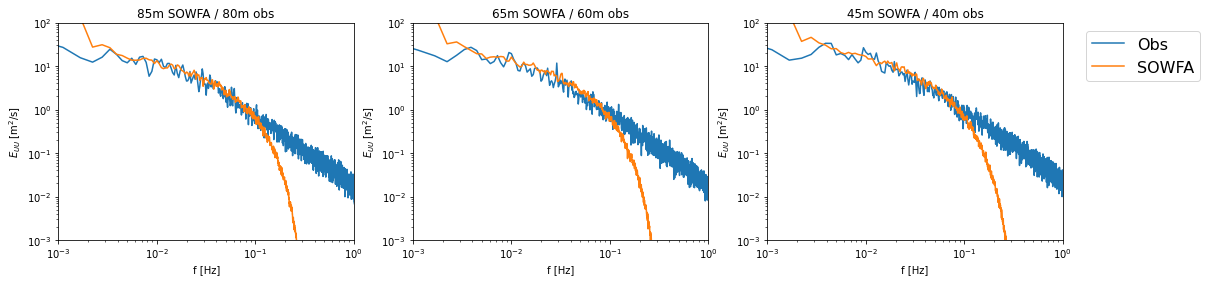

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

_,ax = plot_spectrum(
    datasets={'Obs':psdobs.sel(height=80).to_dataframe(), \
              'SOWFA':psdsowfa.sel(height=85).mean(dim='x').to_dataframe(), },
    #height=80,
    #times=spectraTimes,
    fields='wspd',
    freqlimits=(1e-3,1),
    fieldlimits={'wspd':(1e-3,1e2)},
    showlegend=False,
    fig=fig, ax=axs[0]
)
ax.set_title('85m SOWFA / 80m obs')


_,ax = plot_spectrum(
    datasets={'Obs':psdobs.sel(height=60).to_dataframe(), \
              'SOWFA':psdsowfa.sel(height=65,method='nearest').mean(dim='x').to_dataframe(), },
    #height=80,
    #times=spectraTimes,
    fields='wspd',
    freqlimits=(1e-3,1),
    fieldlimits={'wspd':(1e-3,1e2)},
    showlegend=False,
    fig=fig, ax=axs[1]
)
ax.set_title('65m SOWFA / 60m obs')


_,ax = plot_spectrum(
    datasets={'Obs':psdobs.sel(height=40).to_dataframe(), \
              'SOWFA':psdsowfa.sel(height=45,method='nearest').mean(dim='x').to_dataframe(), },
    #height=80,
    #times=spectraTimes,
    fields='wspd',
    freqlimits=(1e-3,1),
    fieldlimits={'wspd':(1e-3,1e2)},
    fig=fig, ax=axs[2]
)
ax.set_title('45m SOWFA / 40m obs')
plt.show()

## Time-history of mast points

### Obs

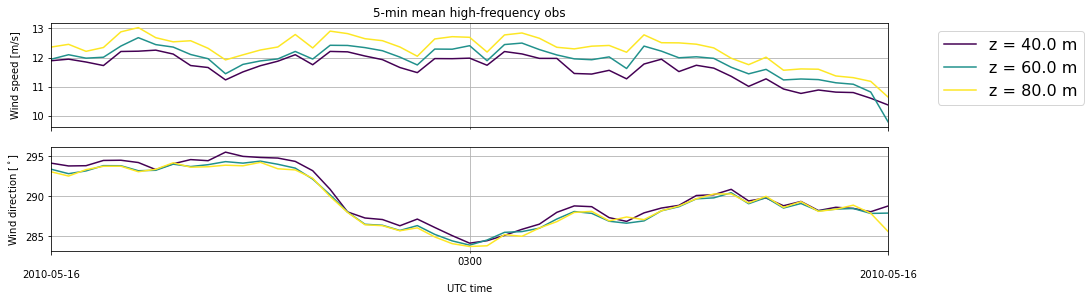

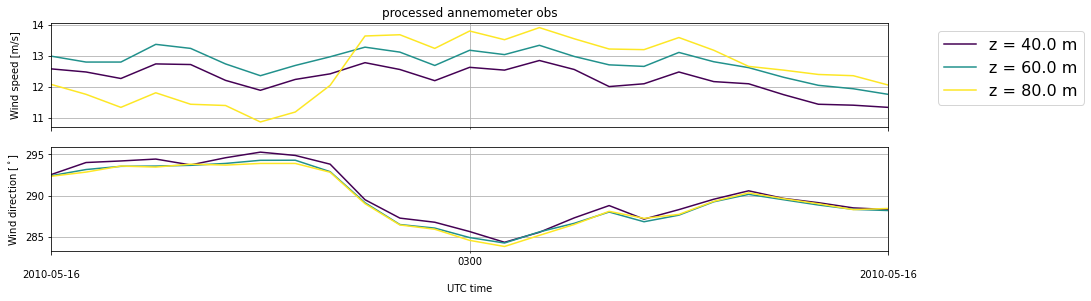

In [26]:
fig,axs = plot_timehistory_at_height(
    obs.resample(datetime='5min').mean(),
    fields=['wspd','wdir'],
    heights=[40,60,80],
    cmap='viridis',
    timelimits=[LESfrom,LESto],
    #fieldlimits={'wspd':(11,21),'wdir':(280,310),'theta':(280,283)},
    plot_local_time=False,
    subfigsize=(15,2.1)
)
axs[0].set_title('5-min mean high-frequency obs')

fig,axs = plot_timehistory_at_height(
    obswill,
    fields=['wspd','wdir'],
    heights=[40,60,80],
    cmap='viridis',
    timelimits=[LESfrom,LESto],
    #fieldlimits={'wspd':(11,21),'wdir':(280,310),'theta':(280,283)},
    plot_local_time=False,
    subfigsize=(15,2.1)
)
axs[0].set_title('processed annemometer obs')

plt.show()

### Microscale

In [27]:
dsmean = dssowfa.mean(dim=['x','y'])
ds00 = dssowfa.sel(x=0,y=0).to_dataframe().drop(columns=['x','y'])

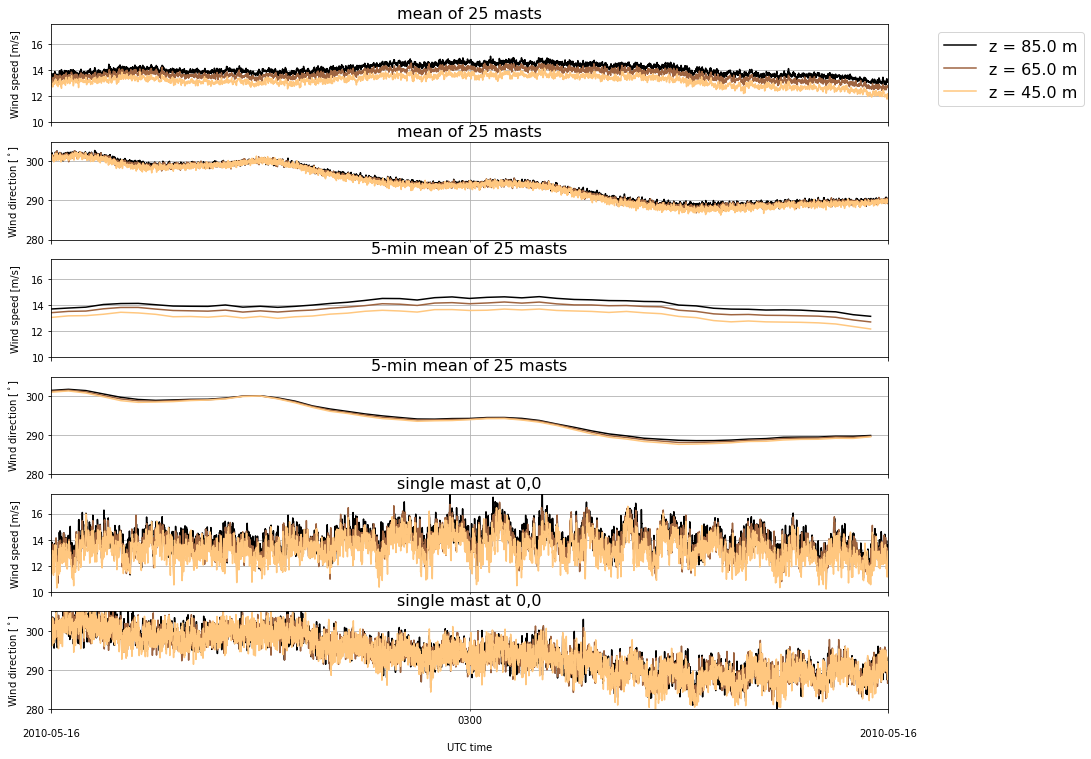

In [28]:
fig,axs = plot_timehistory_at_height(
    datasets={'mean of 25 masts':dsmean,
              '5-min mean of 25 masts':dsmean.resample(datetime='5min').mean(),
              'single mast at 0,0':ds00},
    fields=['wspd','wdir'],
    heights=[85,65,45],
    cmap='copper',
    timelimits=[LESfrom,LESto],
    fieldlimits={'wspd':(10,17.5),'wdir':(280,305)},
    plot_local_time=False,
    subfigsize=(15,2.1)
)

### Comparison of time histories at specific heights

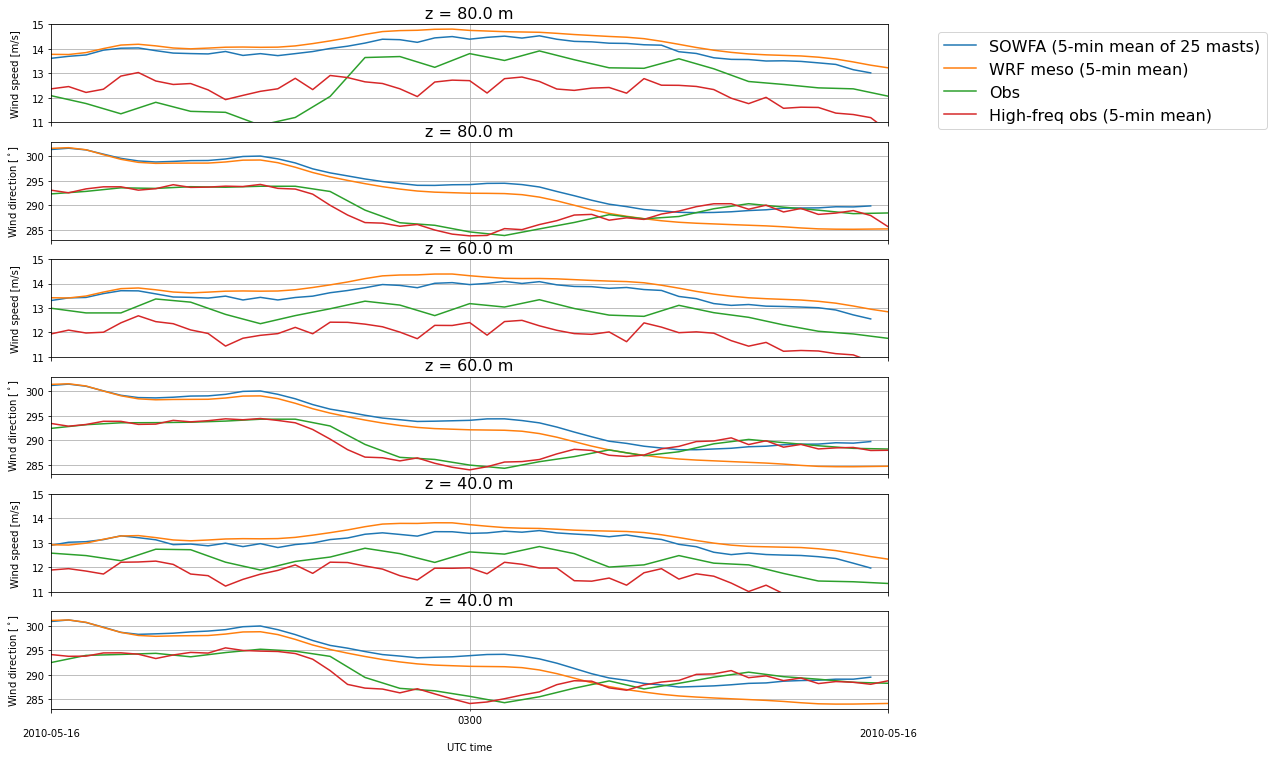

In [29]:
fig,axs = plot_timehistory_at_height(
     datasets={'SOWFA (5-min mean of 25 masts)':dsmean.resample(datetime='5min').mean(),
               'WRF meso (5-min mean)':dswrf.resample(datetime='5min').mean(),
               'Obs':obswill,
               'High-freq obs (5-min mean)':obs.resample(datetime='5min').mean()
              },
    fields=['wspd','wdir'],
    heights=[80,60,40],
    cmap='viridis',
    timelimits=[LESfrom,LESto],
    fieldlimits={'wspd':(11,15),'wdir':(283,303)},
    plot_local_time=False,
    stack_by_datasets=True,
    subfigsize=(15,2.1)
)

## VTK handling

### Instantaneous plots at 02Z, 03Z, 04Z

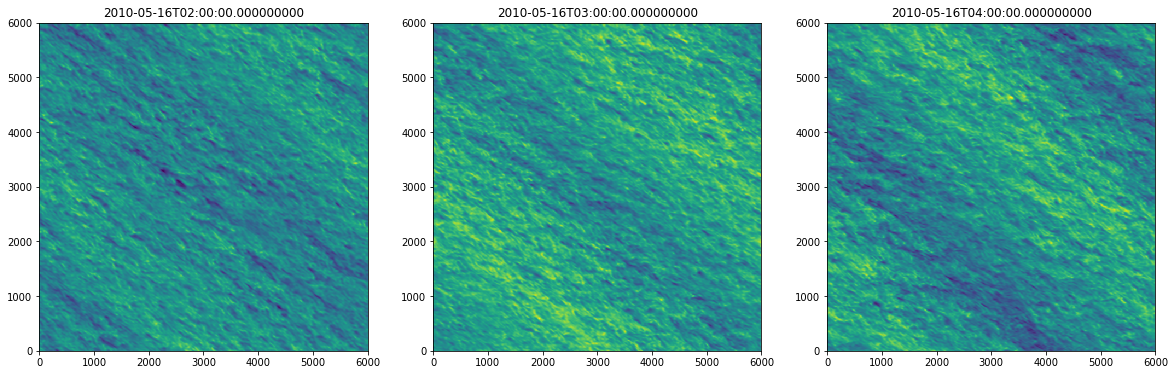

In [30]:
t_hours = [136800, 140400, 144000]
dshours = ds80m.sel(datetime=pd.to_datetime(t_hours, unit='s', origin=dateref))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
for i, ax in enumerate(axs):
    currds = dshours.sel(datetime=dshours.datetime[i])
    p = ax.pcolormesh(currds.x, currds.y, (currds.u**2 + currds.v**2)**0.5, vmin=10, vmax=18, cmap='viridis', shading='auto')

    ax.set_title(dshours.datetime[i].values)
    ax.set_xlim([0,6000])
    ax.set_ylim([0,6000])
    ax.set_aspect('equal', 'box')
    

### Sanity-check mean comparison
Compare the means that is saved from OpenFOAM directly, accounting for the all time steps in the first hour, and the recomposed mean from the instantaneaous flowfield

In [31]:
meanslicedir = '/home/rthedin/OpenFOAM/rthedin-6/run/offshoreCases/02_fino_sampling/postProcessing/slicesWRF'
ds1hour = readVTK(meanslicedir,t=136800, sliceType='UMean_zNormal.80.vtk')
ds2hour = readVTK(meanslicedir,t=140400, sliceType='UMean_zNormal.80.vtk')

Reading a single VTK for time 136800.0
Reading a single VTK for time 140400.00000020955


In [32]:
mean_1hour_reconstruct = ds80m.sel(datetime=slice(LESfrom,LESfrom+pd.Timedelta(seconds=3600))).mean(dim=['datetime'])
mean_2hour_reconstruct = ds80m.sel(datetime=slice(LESfrom,LESfrom+pd.Timedelta(seconds=3600*2))).mean(dim=['datetime'])

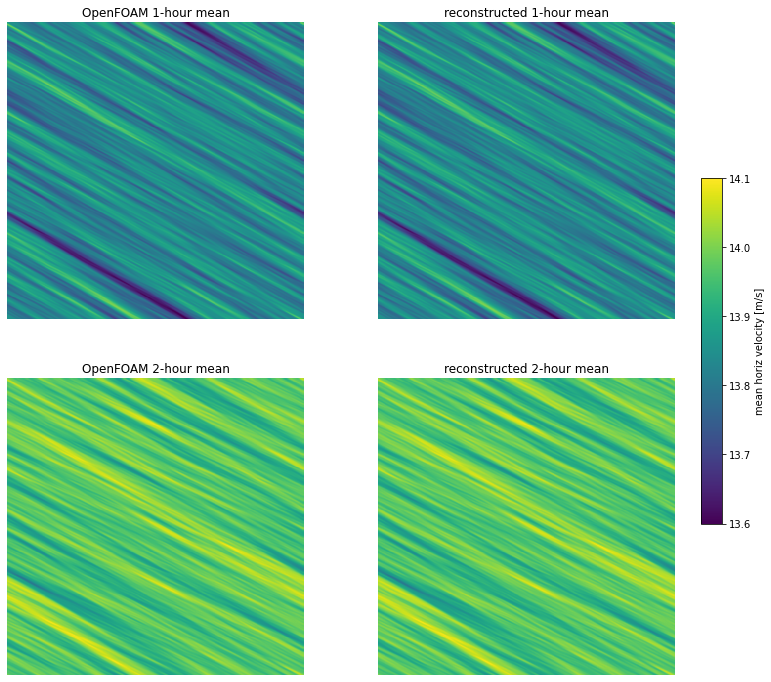

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
ax=axs.flatten()
vmin=13.6
vmax=14.1

p = np.sqrt(ds1hour.u**2 + ds1hour.v**2).plot(ax=ax[0], vmin=vmin, vmax=vmax, shading='auto', cmap='viridis', add_colorbar=False)
ax[0].set_title('OpenFOAM 1-hour mean')

p = np.sqrt(mean_1hour_reconstruct.u**2 + mean_1hour_reconstruct.v**2).plot(ax=ax[1], vmin=vmin, vmax=vmax, shading='auto', cmap='viridis', add_colorbar=False)
ax[1].set_title('reconstructed 1-hour mean')

p = np.sqrt(ds2hour.u**2 + ds2hour.v**2).plot(ax=ax[2], vmin=vmin, vmax=vmax, shading='auto', cmap='viridis', add_colorbar=False)
ax[2].set_title('OpenFOAM 2-hour mean')

p = np.sqrt(mean_2hour_reconstruct.u**2 + mean_2hour_reconstruct.v**2).plot(ax=ax[3], vmin=vmin, vmax=vmax, shading='auto', cmap='viridis', add_colorbar=False)
ax[3].set_title('reconstructed 2-hour mean')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.3, 0.02, 0.4])
cb = fig.colorbar(p, cax=cbar_ax)
cb.set_label('mean horiz velocity [m/s]')

for a in ax:
    a.set_xlim([0,6000]); a.set_ylim([0,6000])
    a.set_aspect('equal', 'box')
    a.axis('off')

## Spatial Correlation

In [34]:
def spatialCorrelation2D (ds, x0, y0, ti=None, tf=None, dateref=None):
    
    # Operations in time
    if dateref != None:
        ti = pd.to_datetime(ti, unit='s', origin = dateref)
        tf = pd.to_datetime(tf, unit='s', origin = dateref)
    ds = ds.sel(datetime=slice(ti,tf)).copy()
    times = ds.datetime.values
    
    if 'wspd' not in list(ds.var()):
        ds['wspd'] = (ds.u**2 + ds.v**2)**0.5
    
    # find position of (x0, y0)
    iNearest = (abs(ds.x-x0)).argmin().values
    jNearest = (abs(ds.y-y0)).argmin().values
    
    print(f'Performing spatial correlation wrt to point ({ds.isel(x=iNearest).x.values}, ' \
          f'{ds.isel(x=iNearest).x.values}), between {ti} and {tf}.')
    
    mean = ds.sel(datetime=slice(ti,tf)).mean(dim=['datetime'])
        
    vlist=[]
    for i, t in enumerate(times):
        print(f'Processing time {t}', end='\r', flush=True)
        primeField = ds.sel(datetime=t) - mean
        v = primeField*primeField.isel(x=iNearest, y=jNearest)
        vlist.append(v)
    
    finalv = xr.concat(vlist, dim='datetime').mean(dim='datetime')
    finalv = finalv/finalv.isel(x=iNearest, y=jNearest)
    
    return finalv

In [35]:
v = spatialCorrelation2D(ds80m, x0=3000, y0=3000, ti=133200, tf=133200+1*3600, dateref=dateref)

Performing spatial correlation wrt to point (3000.0, 3000.0), between 2010-05-16 01:00:00 and 2010-05-16 02:00:00.


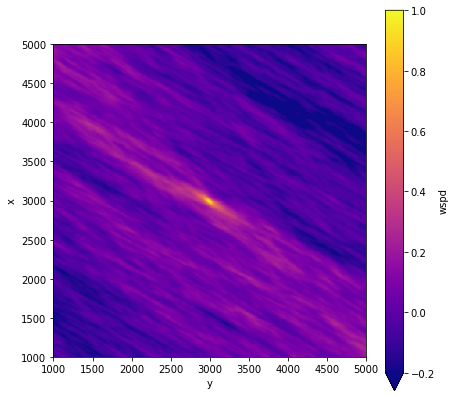

In [36]:
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(7,7))
v.wspd.plot(ax=ax, vmin=-0.2, vmax=1, cmap='plasma')

ax.set_ylim([1000, 5000])
ax.set_xlim([1000, 5000])
ax.set_aspect('equal', 'box')

## Vertical profiles

In [37]:
# 10min mean
obsRaj10min = obs.resample(datetime='10min').mean()
obsWill10min = obswill.copy()
dssowfa10min = dsmean.resample(datetime='10min').mean()
dswrf10min = dfwrf.to_xarray().sel(datetime=slice(LESfrom,LESto)).resample(datetime='10min').mean()

In [38]:
# Find common times on all 10-min mean arrays for plotting purposes
from functools import reduce
times10min = reduce(np.intersect1d,(obsRaj10min.datetime.values, obsWill10min.datetime.values, dssowfa10min.datetime.values, dswrf10min.datetime.values))

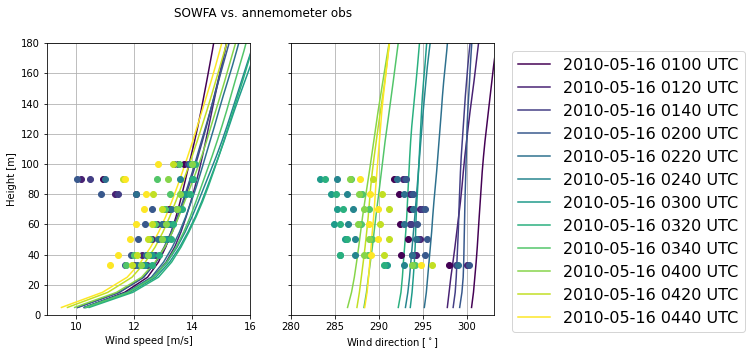

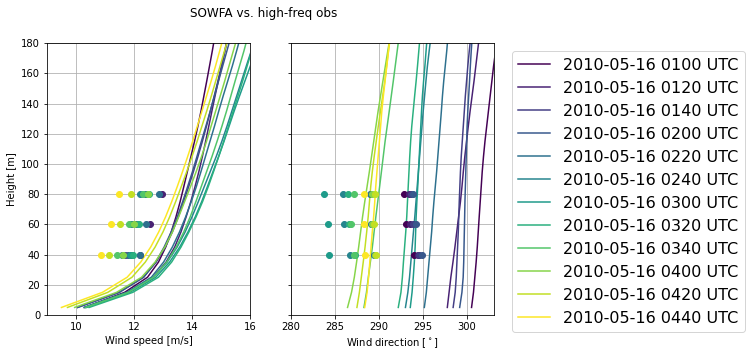

In [39]:
fig,ax = plot_profile(
    datasets={#'10-min mean of 10Hz obs': obsRaj10min,
              #'Obs': obswill,
              'SOWFA': dssowfa10min,
              #'WRF meso':dswrf10min
             },
    fields=['wspd','wdir'],
    times=times10min[::2],
    fieldlimits={'wspd':(9,16),'wdir':(280,303)},
    showlegend=True,
    heightlimits=[0, 180],
    cmap='viridis',
    datasetkwargs={'Obs':dict(linestyle='None', marker='o')},
)

fig,ax = plot_profile(
    datasets={#'10-min mean of 10Hz obs': obsRaj10min,
              'Obs': obswill,
              #'SOWFA': dssowfa10min,
              #'WRF meso':dswrf10min
             },
    fields=['wspd','wdir'],
    times=times10min[::2],
    fieldlimits={'wspd':(9,16),'wdir':(280,303)},
    showlegend=True,
    heightlimits=[0, 180],
    cmap='viridis',
    datasetkwargs={'Obs':dict(linestyle='None', marker='o')},
    fig=fig, ax=ax
)
fig.suptitle('SOWFA vs. annemometer obs');  plt.show()

# ----------------------------------------------------------------------------------------

fig,ax = plot_profile(
    datasets={#'10-min mean of 10Hz obs': obsRaj10min,
              #'Obs': obswill,
              'SOWFA': dssowfa10min,
              #'WRF meso':dswrf10min
             },
    fields=['wspd','wdir'],
    times=times10min[::2],
    fieldlimits={'wspd':(9,16),'wdir':(280,303)},
    showlegend=True,
    heightlimits=[0, 180],
    cmap='viridis',
    datasetkwargs={'Obs':dict(linestyle='None', marker='o')},
)

fig,ax = plot_profile(
    datasets={'10-min mean of 10Hz obs': obsRaj10min,
              #'Obs': obswill,
              #'SOWFA': dssowfa10min,
              #'WRF meso':dswrf10min
             },
    fields=['wspd','wdir'],
    times=times10min[::2],
    fieldlimits={'wspd':(9,16),'wdir':(280,303)},
    showlegend=True,
    heightlimits=[0, 180],
    cmap='viridis',
    datasetkwargs={'10-min mean of 10Hz obs':dict(linestyle='None', marker='o')},
    fig=fig, ax=ax
)
fig.suptitle('SOWFA vs. high-freq obs');  plt.show()

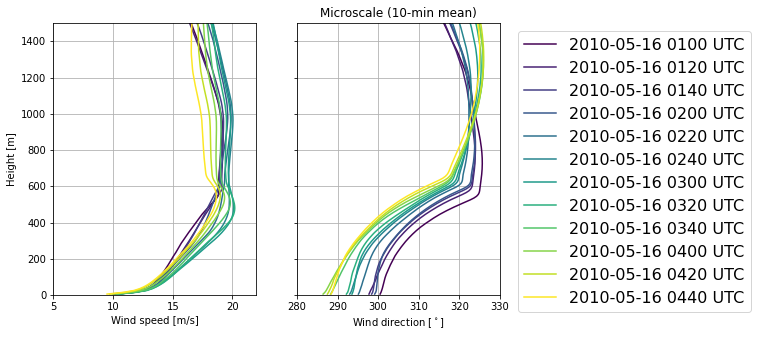

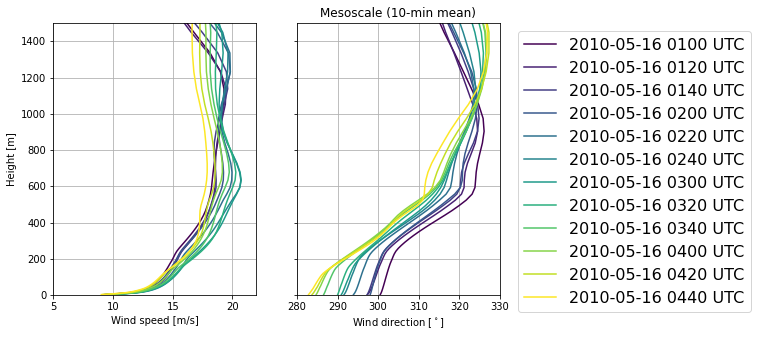

In [40]:
fig,ax = plot_profile(
    dsmean.resample(datetime='10min').mean(),
    fields=['wspd','wdir'],
    times=times10min[::2],
    fieldlimits={'wspd':(5,22),'wdir':(280,330),'theta':(280,290)},
    showlegend=True,
    heightlimits=[0, 1500],
    cmap='viridis'
)
ax[1].set_title('Microscale (10-min mean)')

fig,ax = plot_profile(
    dfwrf.to_xarray().resample(datetime='10min').mean(),
    fields=['wspd','wdir'],
    times=times10min[::2],
    showlegend=True,
    fieldlimits={'wspd':(5,22),'wdir':(280,330),'theta':(280,290)},
    heightlimits=[0, 1500],
    cmap='viridis'
)
ax[1].set_title('Mesoscale (10-min mean)')
plt.show()

### Time-height plots

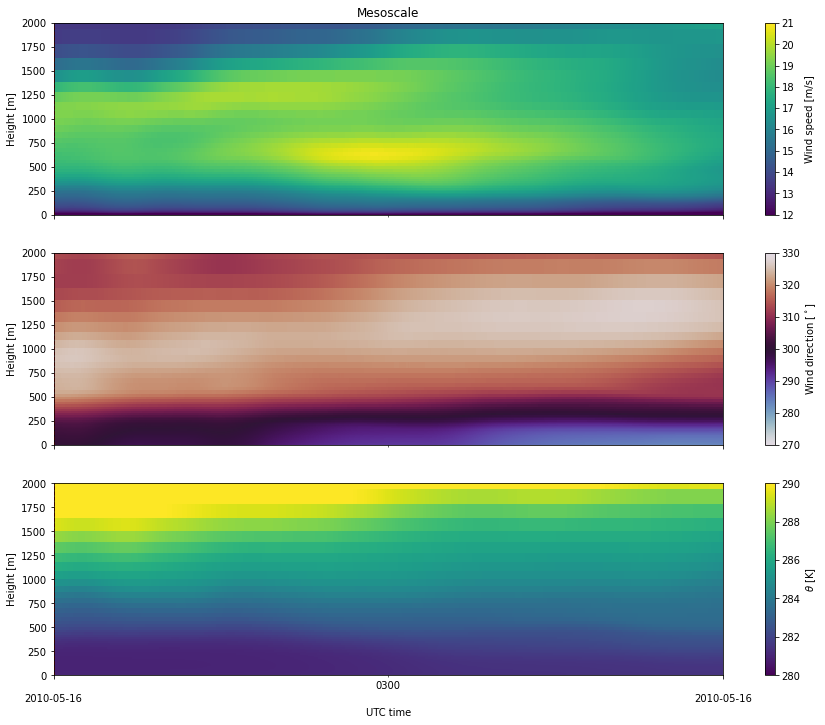

In [41]:
# Mesoscale
fig, axs = plt.subplots(nrows=3,sharex=True,sharey=True,figsize=(15,12))
for ax in axs.reshape(-1): 
    ax.axvline(LESfrom, color='r', linestyle='--', lw=1)
    ax.axvline(LESto, color='r', linestyle='--', lw=1)
axs[0].set_title('Mesoscale')    

fig,axs,cbars = plot_timeheight(dfwrf,
                        fields=['wspd','wdir','theta'],
                        heightlimits=(0,2000),
                        timelimits=[LESfrom,LESto],
                        fieldlimits={'wspd':(12,21),'wdir':(270,330),'theta':(280,290)},
                        subfigsize=(15, 4),
                        fig=fig, ax=axs)

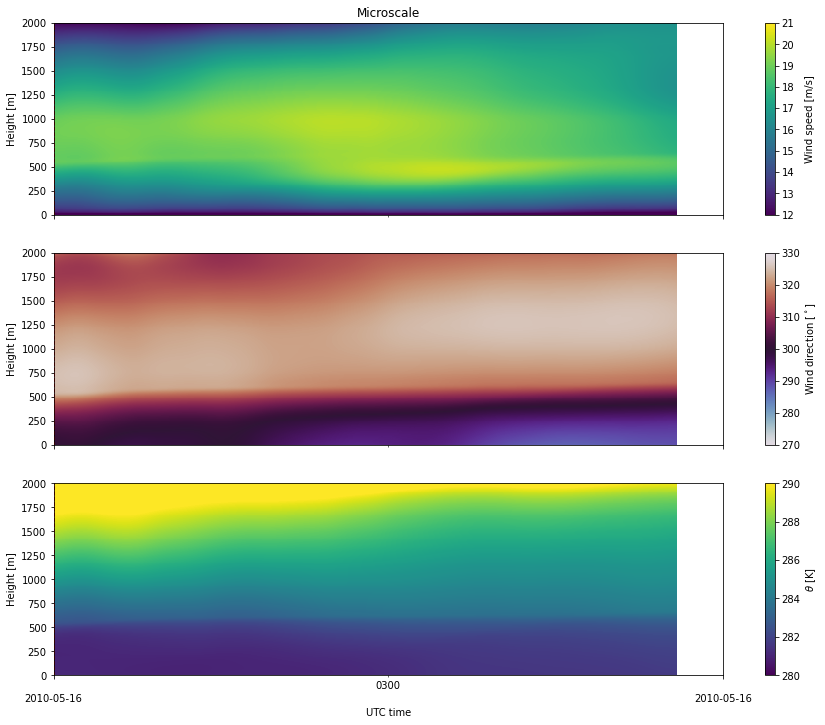

In [42]:
# Microscale
fig, axs = plt.subplots(nrows=3,sharex=True,sharey=True,figsize=(15,12))
for ax in axs.reshape(-1): 
    ax.axvline(LESfrom, color='r', linestyle='--', lw=1)
axs[0].set_title('Microscale')    

fig,axs,cbars = plot_timeheight(dfpa,
                        fields=['wspd','wdir','theta'],
                        timelimits=[LESfrom,LESto],
                        fieldlimits={'wspd':(12,21),'wdir':(270,330),'theta':(280,290)},
                        subfigsize=(15, 4),
                        fig=fig, ax=axs)